## Benson Challenges

Topic:        Challenge Set 1

Subject:      Explore MTA turnstile data

Date:         01/16/2016

Name:         Bauer McClave

Worked with:  Abhisek, Kevin, & Sohrab, Challenges 1-4

**Challenge 1**

In [2]:
import pandas as pd
import numpy as np

In [3]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)
        
week_nums = [160430, 160507, 160514, 160521]
turnstiles_df = get_data(week_nums)

In [4]:
turnstiles_df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,00:00:00,REGULAR,5630154,1906686
1,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,04:00:00,REGULAR,5630200,1906691
2,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,08:00:00,REGULAR,5630228,1906721
3,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,12:00:00,REGULAR,5630337,1906819
4,A002,R051,02-00-00,59 ST,NQR456,BMT,04/23/2016,16:00:00,REGULAR,5630595,1906905


**Challenge 2**

In [5]:
turnstiles_df.columns = [str.lower(column).strip() for column in turnstiles_df.columns]
turnstiles_df["date_time"] = pd.to_datetime(turnstiles_df.date + " " + turnstiles_df.time, format="%m/%d/%Y %H:%M:%S")
turnstiles_df["date"] = pd.DatetimeIndex(turnstiles_df.date)
turnstiles_df["time"] = pd.to_datetime(turnstiles_df['time'], format ='%H:%M:%S').dt.hour

In [6]:
turnstiles_df.head()

,c/a,unit,scp,station,linename,division,date,time,desc,entries,exits,date_time
0,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-23,0,REGULAR,5630154,1906686,2016-04-23 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-23,4,REGULAR,5630200,1906691,2016-04-23 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-23,8,REGULAR,5630228,1906721,2016-04-23 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-23,12,REGULAR,5630337,1906819,2016-04-23 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-23,16,REGULAR,5630595,1906905,2016-04-23 16:00:00


**Challenge 3**

In [7]:
turnstiles_datetime = turnstiles_df
turnstiles_datetime[["prev_date", "prev_entries", "prev_exits"]] = (turnstiles_datetime
                                                       .groupby(["c/a", "unit", "scp", "station","linename"])["date_time", "entries", "exits"]
                                                       .transform(lambda grp: grp.shift(1)))
turnstiles_datetime.dropna(subset=["prev_date"], axis=0, inplace=True)

In [8]:
def get_daily_counts(row, max_counter, origCol, prevCol):
    counter = row[origCol] - row[prevCol]
    if counter < 0:
        # make an assumption
        counter = -counter
    if counter > max_counter:
        return 0
    return counter

In [9]:
turnstiles_datetime['dt_entries'] = turnstiles_datetime.apply(get_daily_counts, axis=1, max_counter=1000000,\
                                                           origCol='entries', prevCol = 'prev_entries')

turnstiles_datetime['dt_exits'] = turnstiles_datetime.apply(get_daily_counts, axis=1, max_counter=1000000,\
                                                         origCol = 'exits', prevCol='prev_exits')

In [10]:
dt_turn_clean = turnstiles_datetime.drop(["entries", "exits", "prev_date", "prev_entries", "prev_exits",], \
                                         axis=1, errors="ignore")

In [11]:
dt_clean = dt_turn_clean.loc[dt_turn_clean['dt_entries']<10000]

In [12]:
dt_clean.head()

,c/a,unit,scp,station,linename,division,date,time,desc,date_time,dt_entries,dt_exits
1,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-23,4,REGULAR,2016-04-23 04:00:00,46.0,5.0
2,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-23,8,REGULAR,2016-04-23 08:00:00,28.0,30.0
3,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-23,12,REGULAR,2016-04-23 12:00:00,109.0,98.0
4,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-23,16,REGULAR,2016-04-23 16:00:00,258.0,86.0
5,A002,R051,02-00-00,59 ST,NQR456,BMT,2016-04-23,20,REGULAR,2016-04-23 20:00:00,366.0,62.0


**Challenge 4**

In [13]:
%matplotlib inline

In [14]:
import matplotlib.pyplot as plt

In [15]:
dt_clean = dt_clean.sort_values(['date_time'], ascending=False)
dates = dt_clean['date_time']
counts = dt_clean['dt_entries']

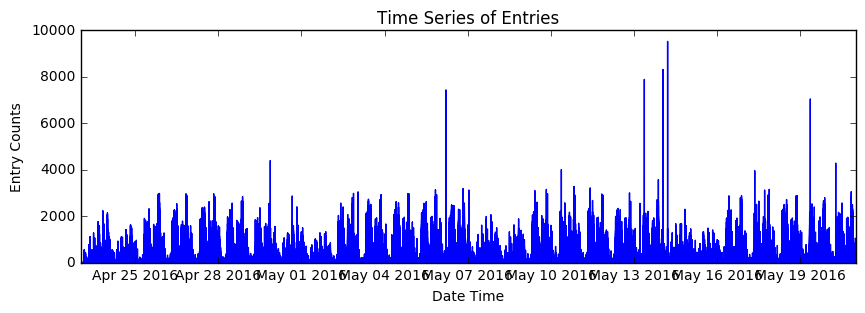

In [16]:
plt.figure(figsize=(10,3))
plt.plot(dates,counts)
plt.xlabel('Date Time')
plt.ylabel('Entry Counts')
plt.title('Time Series of Entries')

**Challenge 5**

In [17]:
daily_clean = dt_clean.groupby(["c/a", "unit", "scp", "station","date"])[['dt_entries','dt_exits']].sum().reset_index()
daily_clean.head()

,c/a,unit,scp,station,date,dt_entries,dt_exits
0,A002,R051,02-00-00,59 ST,2016-04-23,807.0,281.0
1,A002,R051,02-00-00,59 ST,2016-04-24,723.0,273.0
2,A002,R051,02-00-00,59 ST,2016-04-25,1819.0,504.0
3,A002,R051,02-00-00,59 ST,2016-04-26,1677.0,551.0
4,A002,R051,02-00-00,59 ST,2016-04-27,1524.0,563.0


**Challenge 6**

In [20]:
daily_stations = dt_clean.groupby(['station','linename','date'])[['dt_entries','dt_exits']].sum().reset_index()
daily_stations.head()

,station,linename,date,dt_entries,dt_exits
0,1 AV,L,2016-04-23,15118.0,16101.0
1,1 AV,L,2016-04-24,17185.0,18620.0
2,1 AV,L,2016-04-25,20185.0,20866.0
3,1 AV,L,2016-04-26,21370.0,22508.0
4,1 AV,L,2016-04-27,22353.0,22682.0


**Challenge 7**

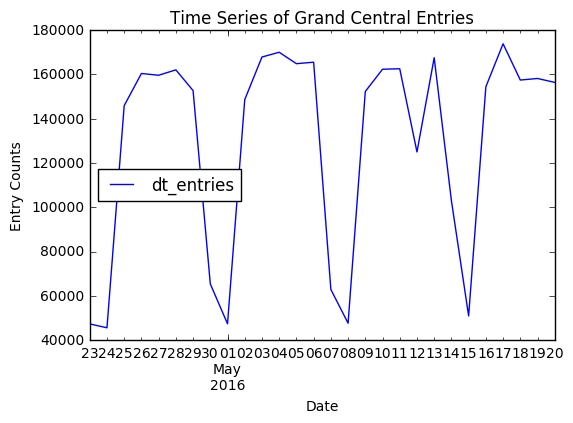

In [25]:
gc_stations = daily_stations[daily_stations['station']=='GRD CNTRL-42 ST']
plt.figure(figsize=(20,10))
gc_stations.plot(x='date', y='dt_entries')
plt.xlabel('Date')
plt.ylabel('Entry Counts')
plt.title('Time Series of Grand Central Entries')

**Challenge 8**

In [26]:
gc_stations['weekdate'] = gc_stations['date'].dt.weekday_name
gc_stations['num_weekdate'] = gc_stations['date'].dt.dayofweek
gc_stations.head()

/Users/bauer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/bauer/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,station,linename,date,dt_entries,dt_exits,weekdate,num_weekdate
8644,GRD CNTRL-42 ST,4567S,2016-04-23,47317.0,45615.0,Saturday,5
8645,GRD CNTRL-42 ST,4567S,2016-04-24,45558.0,40179.0,Sunday,6
8646,GRD CNTRL-42 ST,4567S,2016-04-25,145878.0,127739.0,Monday,0
8647,GRD CNTRL-42 ST,4567S,2016-04-26,160398.0,136529.0,Tuesday,1
8648,GRD CNTRL-42 ST,4567S,2016-04-27,159608.0,137325.0,Wednesday,2


In [27]:
gc_stations_1wk = gc_stations[gc_stations['date']<'2016-04-30']
gc_stations_2wk = gc_stations[(gc_stations.date >= '2016-04-30') & (gc_stations.date < '2016-05-07')]
gc_stations_3wk = gc_stations[(gc_stations.date >= '2016-05-07') & (gc_stations.date < '2016-05-14')]

In [28]:
gc_stations_1wk.head()

,station,linename,date,dt_entries,dt_exits,weekdate,num_weekdate
8644,GRD CNTRL-42 ST,4567S,2016-04-23,47317.0,45615.0,Saturday,5
8645,GRD CNTRL-42 ST,4567S,2016-04-24,45558.0,40179.0,Sunday,6
8646,GRD CNTRL-42 ST,4567S,2016-04-25,145878.0,127739.0,Monday,0
8647,GRD CNTRL-42 ST,4567S,2016-04-26,160398.0,136529.0,Tuesday,1
8648,GRD CNTRL-42 ST,4567S,2016-04-27,159608.0,137325.0,Wednesday,2


In [29]:
week1_count_list = gc_stations_1wk[['num_weekdate','dt_entries']].sort_values(['num_weekdate'], ascending=True).groupby(["num_weekdate"])[['dt_entries']].sum()
week2_count_list = gc_stations_2wk[['num_weekdate','dt_entries']].sort_values(['num_weekdate'], ascending=True).groupby(["num_weekdate"])[['dt_entries']].sum()
week3_count_list = gc_stations_3wk[['num_weekdate','dt_entries']].sort_values(['num_weekdate'], ascending=True).groupby(["num_weekdate"])[['dt_entries']].sum()

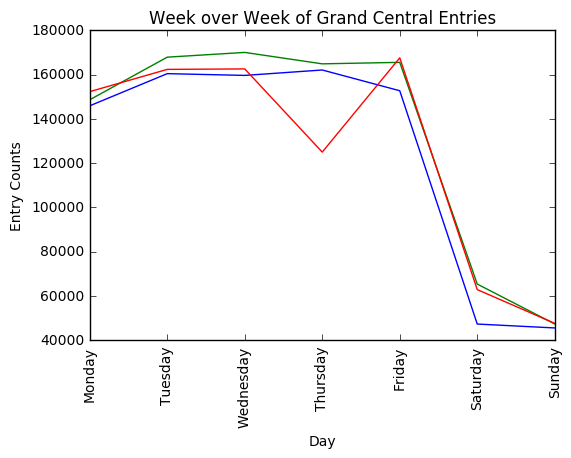

In [31]:
plt.plot(week1_count_list)
plt.plot(week2_count_list)
plt.plot(week3_count_list)
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(week1_count_list.index[:], labels, rotation='vertical')
plt.xlabel('Day')
plt.ylabel('Entry Counts')
plt.title('Week over Week of Grand Central Entries')

**Challenge 9**

In [32]:
station_totals = dt_clean.sort_values(['dt_entries'], ascending=False)
station_totals= station_totals.groupby(['station','linename'])[['dt_entries','dt_exits']].sum().reset_index()
station_totals = station_totals.sort_values(['dt_entries'], ascending=False)

station_totals.head()

,station,linename,dt_entries,dt_exits
309,GRD CNTRL-42 ST,4567S,3637206.0,3184755.0
90,34 ST-HERALD SQ,BDFMNQR,3065851.0,2893063.0
103,42 ST-PORT AUTH,ACENQRS1237,2273033.0,1522926.0
442,TIMES SQ-42 ST,1237ACENQRS,2191342.0,1827934.0
94,34 ST-PENN STA,ACE,1990058.0,2361157.0


**Challenge 10**

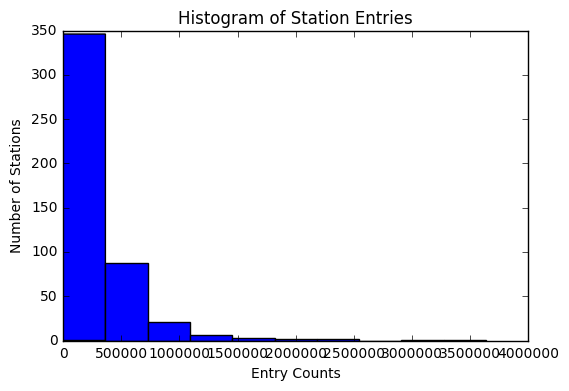

In [34]:
total_ridership_counts = station_totals['dt_entries']
plt.hist(total_ridership_counts)
plt.xlabel('Entry Counts')
plt.ylabel('Number of Stations')
plt.title('Histogram of Station Entries')